In [25]:
# import ocean row module
from mod_ocean_row import ocean_row, parameter_sweeper

from monte_carlo import boat, ocean, State, Action

import plt_utils
import random

import xarray as xr
from collections import namedtuple, deque
# # reload package
import importlib
import mod_ocean_row
import monte_carlo
importlib.reload(mod_ocean_row)
importlib.reload(monte_carlo)
importlib.reload(plt_utils)
from mod_ocean_row import ocean_row

In [26]:
def create_config():
    # create dictionary of starting location
    # Dsloc = {'start_name':'Fremantle'    ,'start_lat':-32.056946,'start_lon':115.743889}
    # Dsloc = {'start_name':'Geraldton'    ,'start_lat':-28.782387,'start_lon':114.607513} 
    Dsloc = {'start_name':'Kalbarri'     ,'start_lat':-27.711053,'start_lon':114.164536} 
    # Dsloc = {'start_name':'Carnarvon'    ,'start_lat':-24.883717,'start_lon':113.656956} 
    # Dsloc = {'start_name':'Exmouth'      ,'start_lat':-21.930724,'start_lon':114.122389} 
    # Dsloc = {'start_name':'Broome'       ,'start_lat':-17.951221,'start_lon':122.244327} 

    # create dictionary of destination location
    Deloc = {'stop_name':'Dar es Salaam' ,'stop_lat':-6.766305  ,'stop_lon':39.195973  } # create dictionary of destination location

    # date and time
    tod_0     = '2018-05-01 03:00:00' # starting datetime
    tod_start = ['06:00:00','14:00:00'] # start rowing [time of day]
    tod_stop  = ['12:00:00','20:00:00'] # stop rowing [time of day]
    Dtime     = {'tod_0':tod_0,'tod_start':tod_start,'tod_stop':tod_stop} # create dictionary

    # rowing properties
    m     = 670 # wiegth [kg]

    # convert m/s to kts
    tokts = 1.94384449 # convert m/s to kts

    # rowing speed perfect conditions
    vperf = 1.7/tokts # boat velocity in perfect conditions [m/s]

    # water friction - boat
    rhow  = 1024 # density water [kg/m^3]
    Aw    = 15 # frontal area exposed to water
    Cdw   = 0.005 # friction coef. water 
    Gw    = rhow*Cdw*Aw/2 # water friction constant

    # water friction - anchor
    GwA   = 50*Gw # water friction constant sea anchor

    # friction ratio boat
    G     = .01 # ratio of air friction cosntant to water friction constant (Ga/Gw)

    # air friction 
    Ga    = G*Gw # air friction constant

    Drow_prop = {'m':m,'vperf':vperf,'Gw':Gw,'GwA':GwA,'Ga':Ga} # create dictionary of all rowing properties

    # combine all configurations
    mcf = Dsloc | Deloc | Drow_prop | Dtime # model configuration (as dictionary)
    return mcf

def load_hindcast():

    # air velocity (wind)
    dsa0 = xr.open_dataset(r'./Data/CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1648775425193.nc').load()
    dsa  = xr.Dataset(
        data_vars=dict(
            # correct wind dataset (wrong direction of winds)
            ua  = (["time", "lat", "lon"], dsa0.eastward_wind.isel(depth=0).values),
            va  = (["time", "lat", "lon"], dsa0.northward_wind.isel(depth=0).values)),
        coords=dict(
            lon  = dsa0.longitude.values,
            lat  = dsa0.latitude.values,
            time = dsa0.time.values))

    # water velocity (currents)
    dsw0 = xr.open_dataset(r'./Data/nemo_monthly_mean.nc').load()
    dsw  = xr.Dataset(
        data_vars=dict(
            uw  = (["time", "lat", "lon"], dsw0.uo.isel(depth=0).values),
            vw  = (["time", "lat", "lon"], dsw0.vo.isel(depth=0).values),
            Tw  = (["time", "lat", "lon"], dsw0.thetao.isel(depth=0).values)),
        coords=dict(
            lon  = dsw0.longitude.values,
            lat  = dsw0.latitude.values,
            time = dsw0.time.values))

    # wave heights 
    dswh0 = xr.open_dataset(r'./Data/cmems_obs-wave_glo_phy-swh_my_multi-l4-2deg_P1D_1648776708969.nc').load()
    dswh  = xr.Dataset(
        data_vars=dict(
            # correct wind dataset (wrong direction of winds)
            H_day_mean = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MEAN.values),
            H_day_max  = (["time", "lat", "lon"], dswh0.VAVH_DAILY_MAX.values)),
        coords=dict(
            lon  = dswh0.longitude.values,
            lat  = dswh0.latitude.values,
            time = dswh0.time.values))

    hc = {'dsa':dsa,'dsw':dsw,'dswh':dswh} # create single dictonary of all datasets
    return hc




In [27]:
mcf = create_config()
hc = load_hindcast()

In [28]:
import numpy as np

In [29]:
domain = mod_ocean_row.ocean_row.create_domain()
b = boat(4, 100, 6, 20, 2, mcf['start_lat'], mcf['start_lon'])
oce = ocean(hc, domain, np.datetime64('2018-05-01 03:00:00'), (40, 40), b)
mc = monte_carlo.MonteCarlo(oce)

In [30]:
mcf


{'start_name': 'Kalbarri',
 'start_lat': -27.711053,
 'start_lon': 114.164536,
 'stop_name': 'Dar es Salaam',
 'stop_lat': -6.766305,
 'stop_lon': 39.195973,
 'm': 670,
 'vperf': 0.8745555566536086,
 'Gw': 38.4,
 'GwA': 1920.0,
 'Ga': 0.384,
 'tod_0': '2018-05-01 03:00:00',
 'tod_start': ['06:00:00', '14:00:00'],
 'tod_stop': ['12:00:00', '20:00:00']}

In [31]:
from tqdm import tqdm

In [32]:
ds = []
trajs = []

In [33]:

for i in tqdm(range(10)):    
    rollout = []
    s = oce.start()
    for j in range(2000):
        a = random.choice(oce.legal_moves([]))
        r, s_new = oce.next_state(s, a)

        sars = [s, a, r, s_new]
        rollout.append(sars)
        s = s_new

    trajs.append(rollout)

  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [34]:
trajs[0][0]

IndexError: list index out of range

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import jax
from jax import numpy as jnp

In [88]:
def plot_trajectory(traj):
    xlims = [30,130] # longitude limits [deg]
    ylims = [-40,0] # latitude limits [deg]
    fig,ax = plt_utils.plt_utils.plt_base_simple(xlims,ylims,10,10) # create figure
    plt.gcf().set_size_inches(13,6)
    ax.set_title("Journey")

    trajstates = np.array(list(map(lambda x: [x[0].lat, x[0].lon], traj)))
    lats, lons = trajstates[:,0], trajstates[:,1]
    pltraj = ax.plot(lons, lats, '-')


In [37]:
reward_discount = 0.999
for i in range(4):
    reward = np.cumsum(np.array(list(map(lambda x: x[2], trajs[i]))) * np.array( [reward_discount**i for i in range(len(trajs[i]))] ))
    plt.plot(reward)



IndexError: list index out of range

In [38]:
np.array([1,2,3]) * np.array([0.1, 0.01, 0.001])

array([0.1  , 0.02 , 0.003])

In [39]:
from collections import deque, namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [40]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [41]:
class DQN(nn.Module):
    def __init__(self, state_dim, output_count):
        super(DQN, self).__init__()

        self.dense1 = nn.Linear(state_dim, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, output_count)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return F.log_softmax(x)


      

In [42]:
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [81]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_actions = 38

policy_net = DQN(2, n_actions).to(device)
target_net = DQN(2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimiser = optim.RMSprop(policy_net.parameters())

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            obs = torch.tensor([state.lat, state.lon], dtype = torch.float32).to(device)
            pred = policy_net(obs)
            return pred.min(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [101]:
memory = ReplayMemory(10000)
def optimise_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.NLLLoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimiser.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimiser.step()


In [102]:
num_episodes = 1

def action_index_to_action(indx):
    if 0 <= indx < 36:
        return Action(True, phi = indx * 10)
    elif indx == 36:
        return Action(False, anchor = False)
    elif indx == 37:
        return Action(False, anchor = True)

for i_episode in range(num_episodes):
    rollout = []
    s = oce.start()
    for j in range(1000):
        a_indx = select_action(s)
        a = action_index_to_action(a_indx.item())
        r, s_new = oce.next_state(s, a)
    
        reward = torch.tensor([r], device=device)

        memory.push(torch.tensor([s.lat, s.lon]), a_indx, torch.tensor([s_new.lat, s_new.lon]), reward)
        
        s = s_new

        optimise_model()

        if j % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())4
        rollout.append(sars)
        

    trajs.append(rollout)

/tmp/ipykernel_42345/3828892082.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x256 and 2x32)

In [ ]:
rollout

[]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

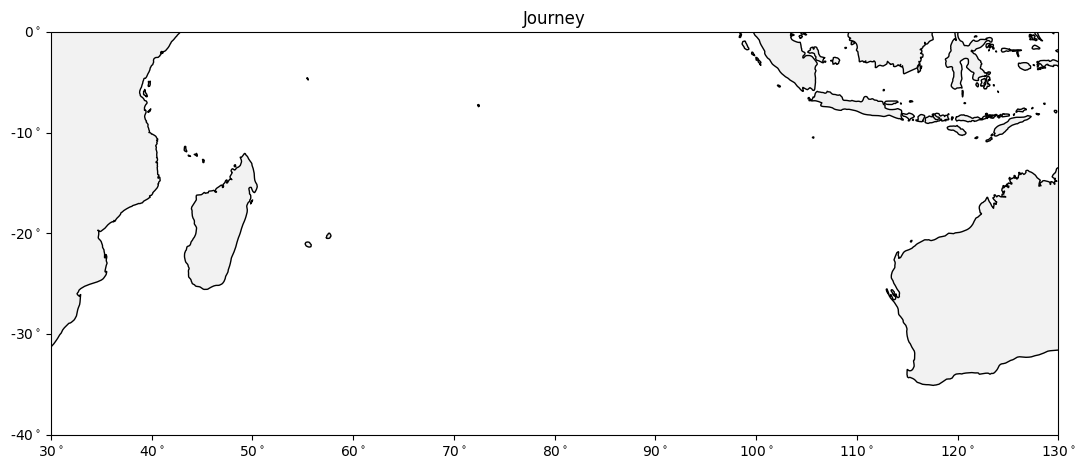

In [96]:

plot_trajectory(rollout)